1. Load the data file and explore the data, showing size, data descriptions,
data distributions with boxplot, pairplots

In [50]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, classification_report, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier

In [24]:
df = pd.read_csv('data.csv', header=None, index_col=0)
columns=['sex', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'y']
df.columns = columns
df.head(5)

,sex,x1,x2,x3,x4,x5,x6,x7,y
0,,,,,,,,,
0,M,0.455,0.365,0.095,0.514,0.2245,0.1010,0.150,2.0
1,M,0.350,0.265,0.090,NaN,0.0995,0.0485,0.070,0.0
2,F,0.530,0.420,0.135,NaN,0.2565,0.1415,0.210,1.0
3,M,0.440,0.365,0.125,0.516,0.2155,0.1140,0.155,1.0
4,I,0.330,0.255,0.080,0.205,0.0895,0.0395,0.055,0.0


In [26]:
print(f'size of df:{df.shape}\n')
print(f'brief description of df\n: {df.describe()}\n')
print(f'types of the columns of df:\n{df.dtypes}')
df.isnull().sum()

size of df:(4177, 9)

brief description of df
:                 x1           x2           x3           x4           x5  \
count  3997.000000  3976.000000  3987.000000  3990.000000  3983.000000   
mean      0.525330     0.408448     0.139669     0.830577     0.360681   
std       0.119569     0.098728     0.041988     0.490629     0.221100   
min       0.075000     0.055000     0.000000     0.002000     0.001000   
25%       0.450000     0.350000     0.115000     0.444500     0.188000   
50%       0.545000     0.425000     0.140000     0.802250     0.339000   
75%       0.615000     0.480000     0.165000     1.154375     0.503250   
max       0.815000     0.650000     1.130000     2.825500     1.488000   

                x6           x7            y  
count  4002.000000  3990.000000  4177.000000  
mean      0.180995     0.239796     0.861623  
std       0.109425     0.139765     0.762510  
min       0.000500     0.001500     0.000000  
25%       0.094000     0.130000     0.000000  
50%

,0
sex,0
x1,180
x2,201
x3,190
x4,187
x5,194
x6,175
x7,187
y,0


<Axes: >

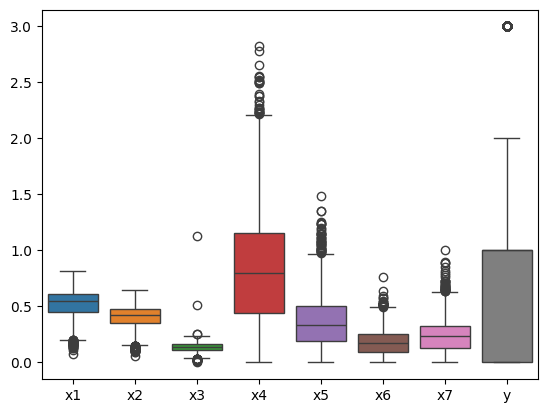

In [22]:
sns.boxplot(df)

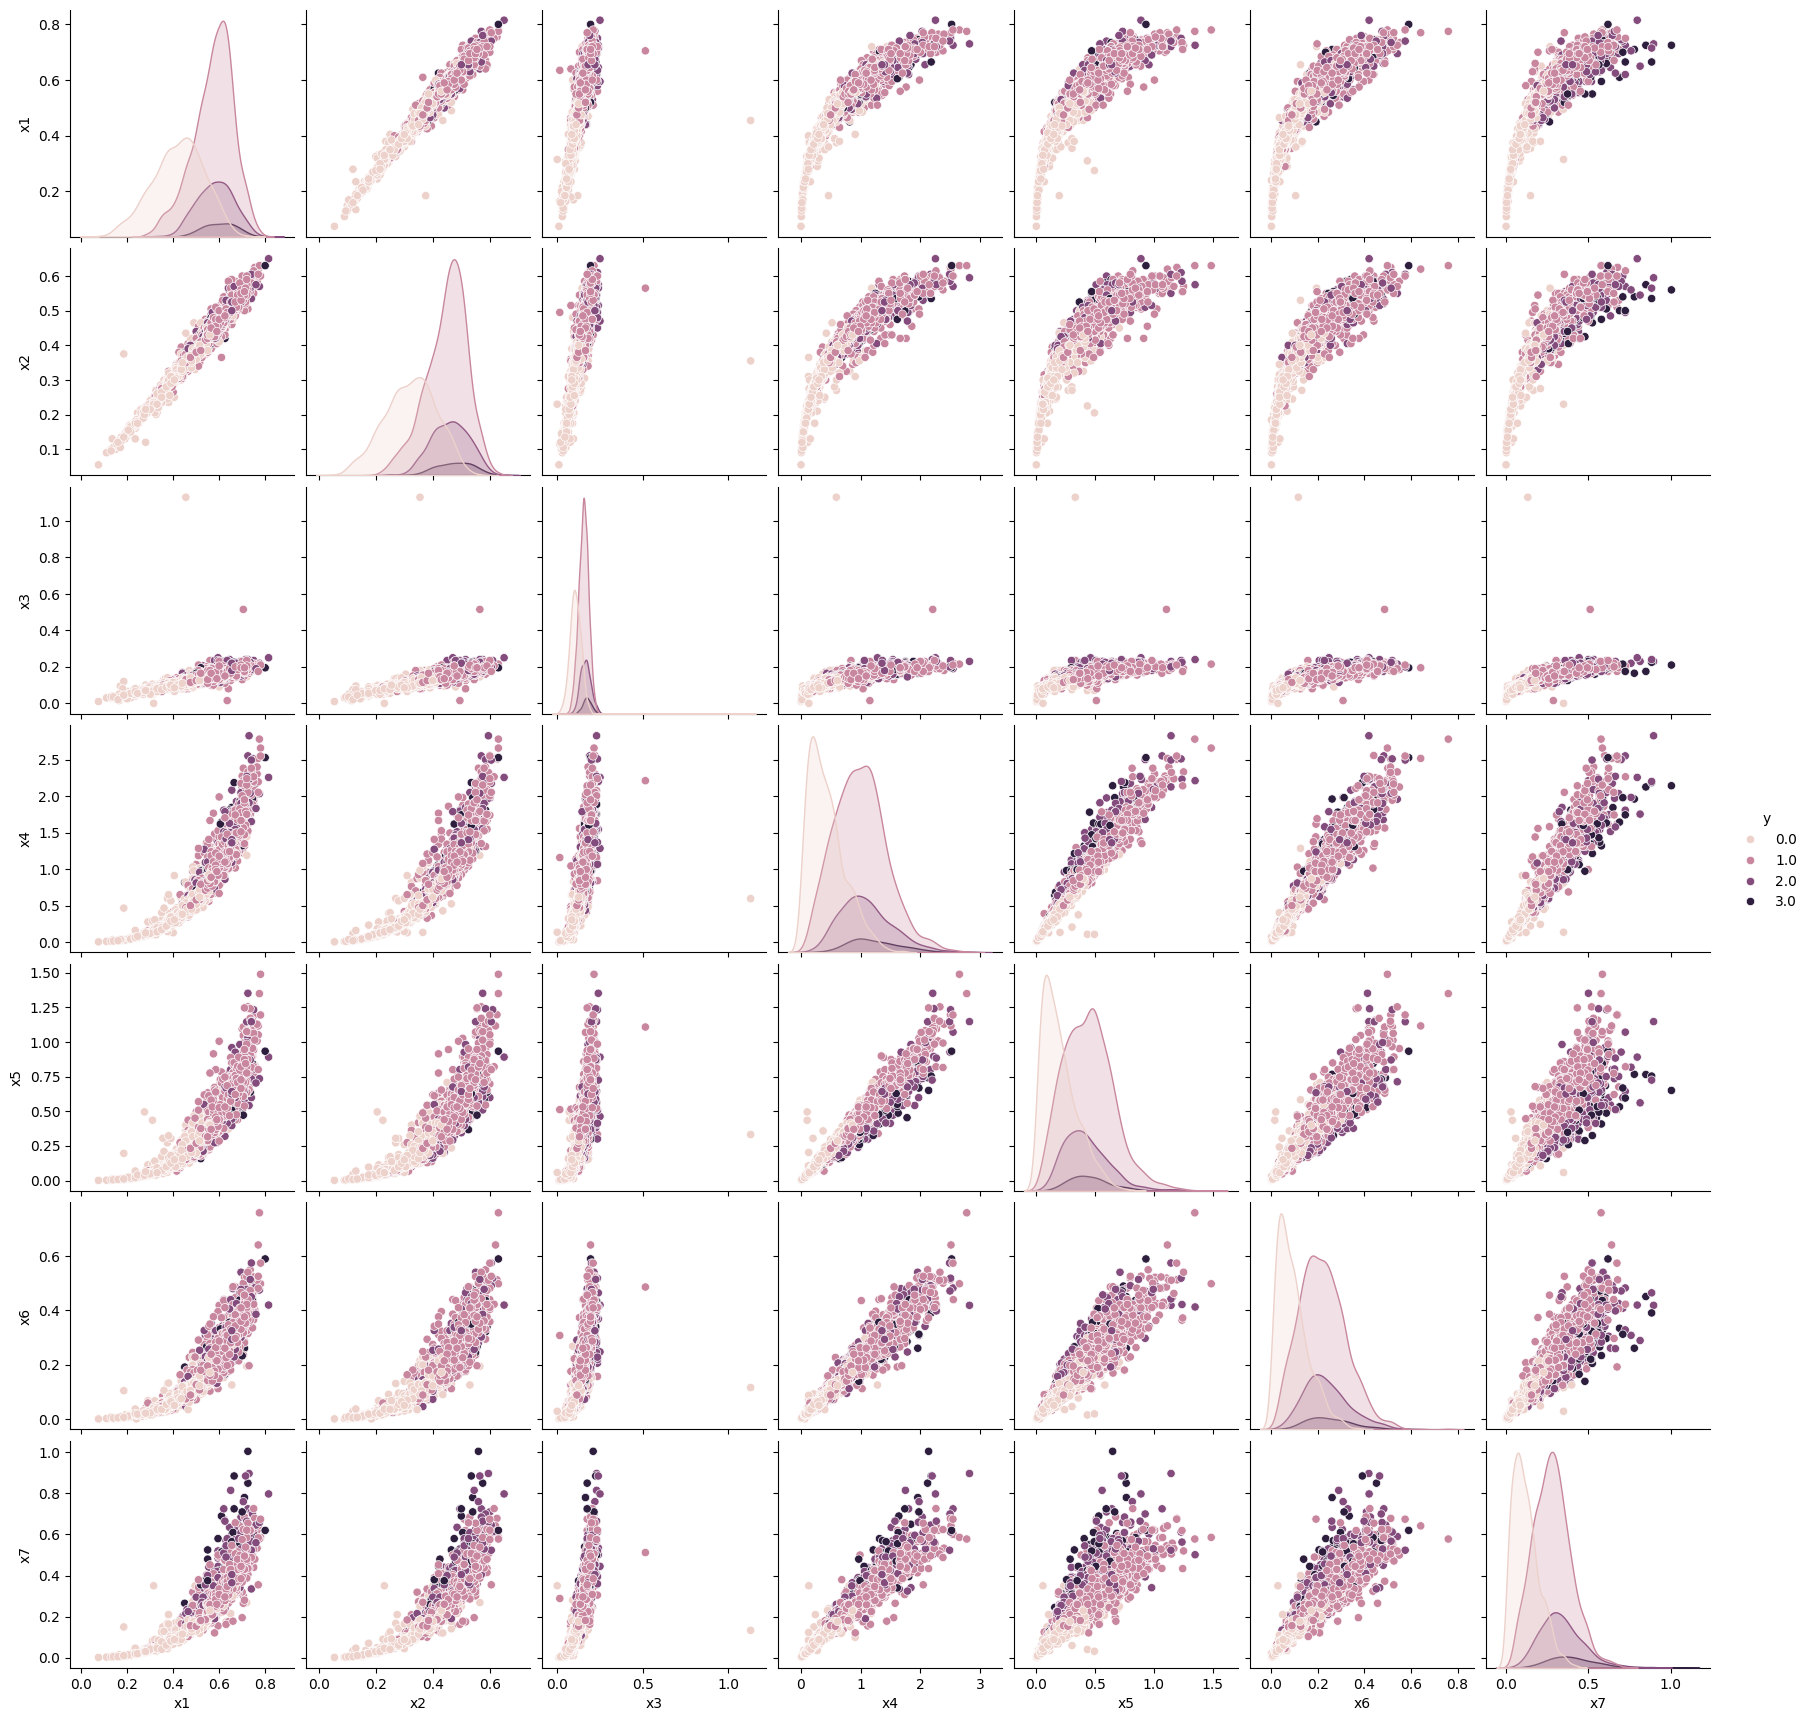

In [25]:
sns.pairplot(data=df, hue='y')

2. Comment the exploration of step 1 pointing out if there are imbalanced
distributions, outliers, missing values

Based on the statistical summary (`describe`) and the distributions observed in Step 1, here are the main findings:

**1. Missing Values**
The dataset is not fully complete.
* **Feature columns (`x1` to `x7`):** All numerical features contain missing values (NaN), ranging from approximately **175 to 200** missing entries per column.
* **Target & Categorical:** The categorical feature `sex` and the target variable `y` are complete (0 missing values).
* *Action:* These missing values will need to be handled in Step 3 (e.g., via imputation) to avoid losing data.

**2. Outliers and Data Anomalies**
* **Invalid Value in `x3`:** The column `x3` shows a minimum value of **0.0**. Since this feature realistically represents a physical dimension, a value of 0 is physically impossible and indicates a noisy data point or a recording error.
* **Skewed Distributions:** Features like `x4` and `x7` show a significant gap between the 75th percentile and the maximum value (e.g., `x4` jumps from 1.15 to 2.82), suggesting the presence of outliers on the higher end of the distribution (that we can also observe looking at the boxplots).

**3. Imbalanced Distributions**
The classification target `y` (Classes 0, 1, 2, 3) is **heavily imbalanced**.
* Looking at the quartiles: the **25th percentile is 0** and the **75th percentile is 1**.
* This implies that classes 0 and 1 combined cover at least **75%** of the entire dataset.
* Classes 2 and 3 are therefore squeezed into the top quartile, making them significantly underrepresented compared to the dominant classes (0 and 1).

3. Drop the columns that are not relevant for the classification operation,
if any, and explain why you do that.
Deal with missing values, if any

<Axes: >

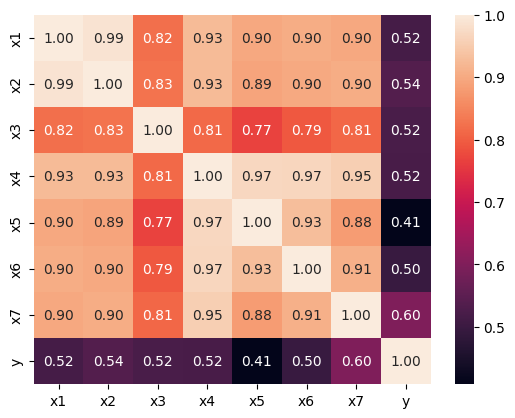

In [33]:
correlation_matrix = df.drop(columns='sex').corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f')

**1. Feature Selection**
Based on the correlation matrix analysis, all numerical features (`x1` to `x7`) show a relevant correlation coefficient with the target variable `y` (feature `sex` is also biologically relevant). No feature shows a close-to-zero correlation that would justify its removal.
* **Decision:** I will keep all the columns to maximize the information available for the model.

**2. Missing Values Handling**
As observed in Step 1, features `x1` to `x7` contain missing values.
* **Strategy:** Since we detected outliers and skewed distributions in Step 2, I will use **Median Imputation** (which is robust to outliers) instead of Mean Imputation.

**3. Categorical Encoding**
The feature `sex` is categorical (M, F, I). To use it in classification algorithms (SVM, KNN, etc.), I will convert it into numerical variables using **One-Hot Encoding**.

In [39]:
imputer = SimpleImputer(strategy='median')
df2 = df.drop(columns=['sex','y'])
dftemp = imputer.fit_transform(df2)
#fit_transform non mi restituisce un df
df2 = pd.DataFrame(dftemp, columns=df2.columns, index=df2.index)
df2.isnull().sum()

,0
x1,0
x2,0
x3,0
x4,0
x5,0
x6,0
x7,0


In [41]:
#sarebbe corretto usare onehotencoder,
# ma sono molte più righe di codice,
# perchè proprio perchè si riutilizza il fit_transform,
# poi dovremmo ritrasformare in un df e poi concatenare le colonne
'''
enc = OneHotEncoder(drop='first', sparse_output=False)
encoded_cols = enc.fit_transform(df2[['sex']])
df2_encoded = pd.DataFrame(encoded_cols, columns=enc.get_feature_names_out(['sex']), index=df2.index)
df3 = pd.concat([df2.drop(columns=['sex']), df2_encoded], axis=1)
'''
# drop_first=True, perchè con 3 sessi, bastano 2 colonne
# (entrambe false = terzo sesso), ci guadagno una colonna in meno
df2 = pd.get_dummies(df, columns =['sex'], prefix='sex',drop_first=True)
df2.head(5)

,x1,x2,x3,x4,x5,x6,x7,y,sex_I,sex_M
0,,,,,,,,,,
0,0.455,0.365,0.095,0.514,0.2245,0.1010,0.150,2.0,False,True
1,0.350,0.265,0.090,NaN,0.0995,0.0485,0.070,0.0,False,True
2,0.530,0.420,0.135,NaN,0.2565,0.1415,0.210,1.0,False,False
3,0.440,0.365,0.125,0.516,0.2155,0.1140,0.155,1.0,False,True
4,0.330,0.255,0.080,0.205,0.0895,0.0395,0.055,0.0,True,False


4. find the best classification scheme considering two classification meth
ods, find the best hyperparameters using cross validation; the optimiza
tion must be focused on the f1_macro measure

In [52]:
x = df2.drop(columns=['y'])
y = df2['y']

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=42)

#non ho voglia di usare lo scaler per i knn, quindi faccio decision tree e random forest

# DECISION TREE
print('DECISION TREE\t')
param_gridDT ={
    'max_depth': [2,5,10,15,20],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2,10]
}
gridDT = GridSearchCV(DecisionTreeClassifier(random_state=42), param_gridDT, scoring = 'f1_macro', cv=5)
gridDT.fit(xtrain, ytrain)
print(f'best DT F1 macro: {gridDT.best_score_:.4f}')
print(f'best dt params:{gridDT.best_params_}')

DECISION TREE	
best DT F1 macro: 0.4890
best dt params:{'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 10}


In [54]:
#RANDOM FOREST
print('RANDOM FOREST\t')

param_gridRF ={
    'max_depth' :  [2,5,10],
    'criterion' : ['gini', 'entropy', 'log_loss'],
    'min_samples_leaf' : [2,4,6],
    'n_estimators': [50]
}

gridRF = GridSearchCV(RandomForestClassifier(random_state=42), param_gridRF, scoring='f1_macro', cv=5,
    n_jobs=-1)
gridRF.fit(xtrain,ytrain)
print(f'best RF F1 macro: {gridRF.best_score_:.4f}')
print(f'best rf params:{gridRF.best_params_}')

RANDOM FOREST	
best RF F1 macro: 0.4832
best rf params:{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 4, 'n_estimators': 50}


In [55]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

FINAL EVALUATION (Test Set)
Model used: Decision Tree (Best Params: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 10})


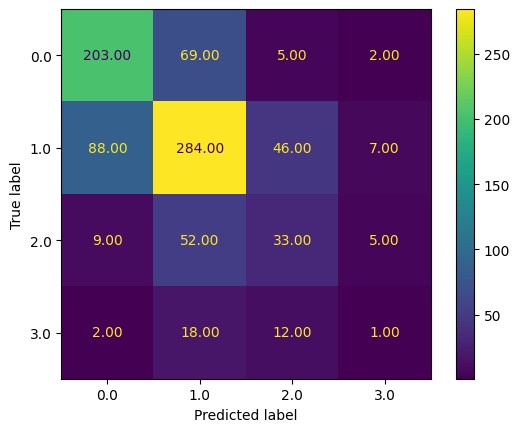

In [57]:
best_model = gridDT.best_estimator_
ypred = best_model.predict(xtest)
print("FINAL EVALUATION (Test Set)")
print(f"Model used: Decision Tree (Best Params: {gridDT.best_params_})")

ConfusionMatrixDisplay.from_predictions(ytest,ypred,values_format='.2f')

**1. Model Selection**
After performing Grid Search on both Decision Tree and Random Forest, the **Decision Tree** emerged as the slightly better model (Best F1 Macro: ~0.49). I selected it for the final evaluation on the test set.

**2. Error Analysis (Confusion Matrix)**
The Confusion Matrix highlights a clear disparity in performance due to dataset imbalance:
* **Good Performance on Majority Classes:** The model successfully identifies Class 0 (203 correct) and Class 1 (284 correct). The majority of the diagonal density is concentrated here.
* **High Misclassification on Minority Classes:**
    * **Class 2:** The model is biased towards the majority class. It misclassified 52 instances of Class 2 as Class 1, which is more than the correctly classified instances (33).
    * **Class 3 (Critical Failure):** The model fails to capture the patterns for Class 3, correctly classifying only **1 single instance**. Most samples (18) were wrongly predicted as Class 1.

**3. Conclusion**
The low F1-Macro score is driven by the model's inability to detect Classes 2 and 3. The model has learned to minimize error by favoring the most frequent classes (0 and 1).
* **Future Improvement:** To address this, techniques such as **SMOTE** (Synthetic Minority Over-sampling Technique) or using **class_weight='balanced'** in the algorithm would be necessary to penalize errors on the minority classes more heavily.